<img 
    style="position: absolute; 
           left: 60%; 
           top: 0; /* Added to ensure proper positioning */
           height: 900px; 
           width: 40%; /* Maintain the original width */
           object-fit: cover; /* Adjust if necessary */
           clip-path: inset(0px 50px 0px 50px round 10px);" 
    src="https://www.mathworks.com/help/examples/stats/win64/ParellelBayeianOptimizationExample_01.png" 
/>

</figure>


<h1 style="width: 60%; color: Orange; font-size: 40pt;">
    <Strong>
        CEGM2003 project: Bayesian optimization for truss structures
    </Strong>
</h1>

<h2 id="Background"><B>
    Background<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>
<p style="text-align: justify; width: 60%; font-weight: normal;">
     Structures that make optimal use of the material they are made of reduces the cost and environmental impact of their construction as the amount of material required. Optimization of structural design is a challenging task because of the high number of design parameters and the relatively expensive evaluation of the suitability of any given design. Standard optimization techniques in high-dimensional design space require a very large number of possible designs that need to be evaluated. In structural analysis, where evaluating the objective function and checking the constraints involves the solution of a structural mechanics problem, e.g. with finite elements, this quickly becomes very expensive, even if the model is relatively simple from structural point of view. Bayesian optimization is a machine-learning-based optimization technique that aims to reduce the number of evaluations of the objective function through data-driven exploration of the design space with a probabilistic surrogate.
</p>

<h2 id="Background"><B>
    Objective & Description<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>

<div style="width: 60%; border-top: 4px solid #34D058; border-left: 4px solid #34D058; background-color: #F6FFED; padding: 1em 1em 1em 1em; color: #24292E; margin: 10px 0 20px 0; box-sizing: border-box;">
    <div style="background-color: #34D058; color: white; padding: 0.2em 1em; margin: -1em -1em 0em -1em; font-size: 1.2em;"><strong>Project Objective</strong></div>
    <p><strong>The aim of this project is to find an optimal truss design,</strong><br>
    this will be achieved by finding an optimal set of nodal coordinates and cross-sectional properties. The primary objective is to minimize the total weight of the structure, while satisfying structural requirements. Optionally, additional objectives can be included, e.g. on the minimization of cutoff waste when reusing components from an existing inventory of elements.</p>
</div>

## <strong> X | Imports</strong>

In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
import sys
import pandas as pd
import io
import os
import botorch

from tabulate import tabulate
from contextlib import redirect_stdout
from sklearn.preprocessing import MinMaxScaler

from botorch.utils.transforms import normalize
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.utils.transforms import unnormalize

sys.path.append('../pyJive/')
from utils import proputils as pu
from names import GlobNames as gn
import main

In [ ]:
# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

## <strong> X | Classes & Dependencies</strong>

In [97]:
class TRUSS():
    def __init__(self, file_path, file_name, output_path, write_name, violation_penalty, scalers, bounds, lower_area=4e-3, freq_constraints=[20, 40, 60], mass_weight=1, freq_weight=1):
        # Configuration Parameters
        self.config = {
            "read_file_path": file_path,
            "read_file_name": file_name,
            "write_file_path": output_path,
            "write_file_name": write_name,
            "violation_penalty": violation_penalty,
            "scalers": {"y": scalers[0], "a": scalers[1]},
            "lower_area": lower_area,
            "bounds" : bounds,
            "freq_constraints": freq_constraints,
            "mass_weight": mass_weight,
            "freq_weight": freq_weight,
            "density": 7850,  # kg/m^3 As per Garnachos
        }

        self.state = {
            "nodes": {},
            "connectivity": None,
            "member_df": None,
            "y_coordinates": None,
            "x_coordinates": None,
            "cross_sections": None,
            "lengths": None,
            "min_mass": 700,
            "monitor_df": None
        }

        self.columns = ["Metric", "Total Loss", "Natural Frequencies", "Mass of Truss", "Normalized Mass Loss", "Frequency Penalty", "Constraint Violation (Loss No W)"]
        self.state["monitor_df"] = pd.DataFrame(columns=self.columns)
    # -------------------------- Import & Writing Files -------------------------- #
    def read_geom_file(self):
        path = os.path.normpath(os.path.join(self.config["read_file_path"], self.config["read_file_name"]))
        with open(path, 'r') as file:
            lines = file.readlines()

        nodes = {}
        members = []
        section = None

        for line in lines:
            line = line.strip()
            if line.startswith('node:'):
                section = 'node'
            elif line.startswith('member:'):
                section = 'member'
            else:
                if section == 'node' and line:
                    parts = line.split()
                    node_number = int(parts[0])
                    node_data = tuple(map(float, parts[1:]))
                    nodes[node_number] = node_data
                elif section == 'member' and line:
                    member_data = tuple(map(int, line.split()))
                    members.append(member_data)

        self.state["nodes"] = nodes
        self.state["member_df"] = pd.DataFrame(members, columns=['Node #1', 'Node #2', 'Number of Elements', 'Cross-section Type'])

        connectivity = self.state["member_df"].to_numpy()
        self.state["connectivity"] = connectivity[:, :2]
        self.state["y_coordinates"] = np.array([value[1] for _, value in nodes.items()])
        self.state["x_coordinates"] = np.array([value[0] for _, value in nodes.items()])

    def get_write_geom_file(self,path_,write_file): 
        path = os.path.normpath(os.path.join(path_,write_file))
        file = open(path)

        for i, (x, _) in self.state["nodes"].items():
            self.state["nodes"][i] = (x, self.state["y_coordinates"][i])

        geom = 'node: node #, x-coordinate; y-coordinate\n'
        for node_num, coords in self.state["nodes"].items():
            geom += f"{node_num} {' '.join(map(str, coords))}\n"
        
        connectivity = self.state["member_df"].to_numpy()
        geom += '\nmember: Node #1; Node #2; number of elements; cross-section type\n'
        for row in connectivity:
            geom += ' '.join(map(str, row)) + '\n'

        output_file_path = os.path.normpath(os.path.join(path_,'TRUSS.geom'))
        with open(output_file_path, 'w') as file:
            file.write(geom)
            
        return file.name
    
    def fit_scalers(self, initial_data):
        y_data = initial_data[:5].reshape(1, -1).T
        a_data = initial_data[5:].reshape(1, -1).T
        self.config["scalers"]["y"].fit(y_data)
        self.config["scalers"]["a"].fit(a_data)

    def scaler(self, mode, x_values, scaler_type):
        scaler = self.config["scalers"][scaler_type]
        x_values = x_values.reshape(1, -1).T
        if mode == 'scale':
            scaled_values = scaler.transform(x_values)
        elif mode == 'descale':
            scaled_values = scaler.inverse_transform(x_values)
        return scaled_values.flatten()
    
    def areas_coordinates_write_split(self, x_list):        
        y_coordinates = np.copy(self.state["y_coordinates"])  # Use a copy to avoid modifying the original array directly
        areas = x_list[5:]
        y_coords = x_list[:5]
        for i, y in enumerate(y_coords, start=1):
            y_coordinates[2 * i] = y
            y_coordinates[20 - 2 * i] = y

        self.state["y_coordinates"] = y_coordinates  # Update state

        return areas, y_coords
    # ---------------------------------------------------------------------------- #
    #                                TARGET FUNCTION                               #
    # ---------------------------------------------------------------------------- #
    def loss_function(self, x_list):
        """
        Calculate the loss for a given set of design parameters.
        Parameters:
        x_list (list): A list of design parameters.
        Returns:
        float: The calculated loss based on mass, frequency constraints, and imaginary penalties.
        """

        if isinstance(x_list,torch.Tensor):
            x_list = x_list.detach().cpu().numpy().flatten()
            self.temporary = x_list
        A_list, y_list = self.areas_coordinates_write_split(x_list)
        mass_truss = self.mass_truss(A_list, y_list)
        
        freq1, freq2, freq3 = self.eigenfrequencies(A_list)
        frequencies = [freq1, freq2, freq3]

        freq_penalty = 0
        for f, t in zip(frequencies, self.config["freq_constraints"]):
            diff = f - t
            penalty_factor = 1 if diff >= 0 else self.config["violation_penalty"]
            freq_penalty += penalty_factor * (np.abs(diff) / t)
                
        normalized_mass_penalty = (mass_truss - 350) / 350
        normalized_freq_penalty = freq_penalty / len(self.config["freq_constraints"])
        constraint_violation = normalized_freq_penalty + normalized_mass_penalty

        LOSS = (self.config["mass_weight"] * normalized_mass_penalty +
                self.config["freq_weight"] * normalized_freq_penalty)
        # -------------------------- Optimisation monitoring ------------------------- #
        optmonitor_data = [
            ["Metric","Total Loss", "Natural Frequencies", "Mass of Truss", "Normalized Mass Loss", "Frequency Penalty", "Constraint Violation (Loss No W)"],
            ["Value",LOSS, frequencies, mass_truss, normalized_mass_penalty, normalized_freq_penalty, constraint_violation]
        ]
        print(f'{tabulate(optmonitor_data, headers="firstrow", tablefmt="grid")}\n')
        
        row_data = optmonitor_data[1][0:]
        new_data = pd.DataFrame([row_data], columns=self.columns)
        self.state["monitor_df"] = pd.concat([self.state["monitor_df"], new_data], ignore_index=True)

        return LOSS

    # ----------------------------- SUPPORT FUNCTIONS ---------------------------- #
    def eigenfrequencies(self,A_list):
        path = os.path.normpath(os.path.join(self.config["read_file_path"], 'bridge_frequency.pro'))
        
        props = pu.parse_file(path)
        props['model']['truss']['area'] = A_list
        props['init']['mesh']['file'] = self.get_write_geom_file(self.config["write_file_path"], self.config["write_file_name"])
        
        trap = io.StringIO()
        with redirect_stdout(trap):
            globdat = main.jive(props)
        
        return (globdat[gn.EIGENFREQS][0:3] / 2 / np.pi)

    def mass_truss(self,areas, y_list):
        x_coordinates = self.state["x_coordinates"]
        y_coordinates = self.state["y_coordinates"]
        
        for i, y in enumerate(y_list, start=1):
            y_coordinates[2 * i] = y
            y_coordinates[20 - 2 * i] = y

        coordinates = list(zip(x_coordinates, y_coordinates))
        lengths = np.zeros(len(self.state["connectivity"]))
        for i, (node1, node2) in enumerate(self.state["connectivity"]):
            x1, y1 = coordinates[node1 - 1]  # Adjusting index to start from 0
            x2, y2 = coordinates[node2 - 1]
            lengths[i] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        n_elements = self.state["member_df"].iloc[:,2].sum()
        areas_i = np.zeros(n_elements)
        cross_section_number = self.state["member_df"].iloc[:,-1] 
        
        for i,item in enumerate(cross_section_number):
                areas_i[i] = areas[item]
        self.temporary = areas_i
        self.state["cross_sections"] = areas[:15]
        self.state["lengths"] = lengths

        volumes = lengths * areas_i
        total_volume = np.sum(volumes)
        dens = 7800
        mass = total_volume * dens

        return mass
    # ----------------------------------- OTHER ---------------------------------- #
    def Initial_guess(self, optim_dims):
        sampled_points = np.zeros(len(optim_dims))
        for i, dim_index in enumerate(optim_dims):
            lower_bound, upper_bound = bounds[i]
            sampled_points[i] = np.random.uniform(lower_bound, upper_bound)
        return sampled_points


In [110]:
# ------------------------------ OTHER FUNCTIONS ----------------------------- #
def SC_wrapper(mode,x,scaler):
    return TRUSS1.scaler(mode,x, scaler)

def objective_function(x):
    return TRUSS1.loss_function(x)

def final_results(file_path, OBJECT, best_x, cross_sections):
    # Read the input file and store in props object
    areas ,y_coords = OBJECT.areas_coordinates_write_split(best_x)
    mass = OBJECT.mass_truss(areas, y_coords)
    OBJECT.get_write_geom_file(file_path, 'TRUSS.geom')

    path = os.path.normpath(os.path.join(file_path,'bridge_frequency_truss.pro'))
    props = pu.parse_file(path)
    props['model']['truss']['area'] = cross_sections
    props['init']['mesh']['file'] = OBJECT.get_write_geom_file(file_path,"TRUSS.geom" )

    # Call the program and store output in globdat
    trap = io.StringIO()
    with redirect_stdout(trap):
        globdat = main.jive(props)

# <strong> Default</strong>

## <strong> 1 | Initialisation</strong>

In [83]:
# -------------------------------- Definitions ------------------------------- #
read_file_path = '../truss_bridge/data'
read_file = 'bridge.geom'
write_file_path =  '../truss_bridge/data/@TRUSS'
write_file = 'TRUSS.geom'

optim_dims = [i for i in range(20)]  
lower_area = 4e-3
violation_factor = 10
freq_constraints = [20,40,60]
mass_weight = 5
freq_weight = 2
A_bound = (0.0001, 0.01)
y_bound = (0.5, 2)

scalers = [MinMaxScaler(),MinMaxScaler()] # [y_scaler, a_scaler]
A_lower = (lower_area - A_bound[0], lower_area + A_bound[0])
bounds = np.array([y_bound if index <= 4 else A_bound for index in optim_dims])

TRUSS1 = TRUSS(read_file_path,
               read_file,
                write_file_path,
                write_file,
                violation_factor,
                scalers,
                bounds,
                freq_constraints= freq_constraints, 
                mass_weight= mass_weight, 
                freq_weight= freq_weight)
TRUSS1.read_geom_file()

In [118]:
# -------------------------------- Initiation -------------------------------- #
x_def = np.concatenate((y_coords, areas))
n_samples = 30 #Large Number to fit the scaler adequately
x_list = []
y_list = []
x_list_sc = []

for _ in range(n_samples):
    x_c = np.copy(x_def) 
    x_random = TRUSS1.Initial_guess(optim_dims)
    x_c[optim_dims] = x_random
    x_list.append(x_c)

trap = io.StringIO()
with redirect_stdout(trap):
    for x in x_list:
        LOSS = TRUSS1.loss_function(x)
        y_list.append(LOSS)

# ---------------------------- INITIATE OPTIMISER ---------------------------- #
bounds = torch.tensor(bounds.T)
X_init = torch.tensor(x_list)
X_init_norm = normalize(X_init, bounds=bounds)  
Y_init = torch.tensor(y_list).reshape(-1,1)

ValueError: too many values to unpack (expected 2)

## <strong> 2 | Optimisation </strong>

In [86]:
n_iter = 100
batch_size = 50
Nrestats = 10

gp_model = SingleTaskGP(X_init_norm, Y_init)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

c:\Users\javie\Documents\@JF\JF\Lib\site-packages\botorch\models\utils\assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
c:\Users\javie\Documents\@JF\JF\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([37.7531], dtype=torch.float64), std = tensor([7.2002], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [87]:
for iteration in range(n_iter):
    
    acq_func = ExpectedImprovement(model=gp_model, best_f=Y_init.min(), maximize=False)
    new_x, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts= Nrestats,
        raw_samples= batch_size,
    )

    new_x_unnorm = unnormalize(new_x, bounds=bounds)
    new_y = objective_function(new_x_unnorm)
    new_y = torch.tensor(new_y, dtype=torch.float32).reshape(1,-1)
    
    X_init_norm = torch.cat([X_init_norm, new_x])
    Y_init = torch.cat([Y_init, new_y])
   
    
    gp_model.set_train_data(inputs=X_init_norm, targets=Y_init.flatten(), strict=False)
    fit_gpytorch_model(mll)

+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------------+
| Metric   |   Total Loss | Natural Frequencies                                         |   Mass of Truss |   Normalized Mass Loss |   Frequency Penalty |   Constraint Violation (Loss No W) |
+==========+==============+=============================================================+=================+========================+=====================+====================================+
| Value    |      8.52247 | [11.692418212430008, 33.890144563390216, 61.70243293727256] |         680.123 |                0.94321 |             1.90321 |                            2.84642 |
+----------+--------------+-------------------------------------------------------------+-----------------+------------------------+---------------------+------------------------------------+

+----------+--------------+------------

## <strong> 3 | Results </strong>

In [91]:
best_ind = Y_init.argmin()
best_x = X_init_norm[best_ind]
best_y = Y_init[best_ind]
best_x_unorm = unnormalize(best_x, bounds=bounds)

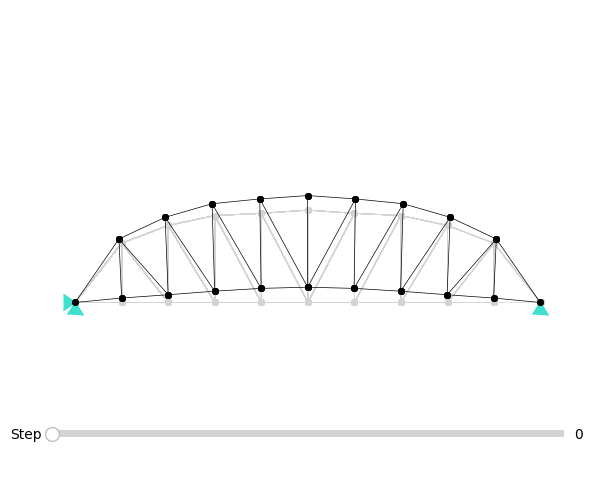

In [111]:
final_results(write_file_path, TRUSS1, best_x_unorm , TRUSS1.state["cross_sections"])